# <center> Проект: классификация 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import RFE
import optuna
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df[(df['balance'].isna())].count()

age          25
job          25
marital      25
education    25
default      25
balance       0
housing      25
loan         25
contact      25
day          25
month        25
duration     25
campaign     25
pdays        25
previous     25
poutcome     25
deposit      25
dtype: int64

Ответ: в признаке 'balance'  - 25 пропущенных значений

### Задание 2

In [6]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0 $,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,"830,00 $",yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,"545,00 $",yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,"1,00 $",yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Ответ: в признаке 'job' - 70 пропущенных значений 

### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def get_balance(balance):
    """Функция преобрахует удаляет из полученной переменной знак: '$', ',' , и приводит полученное значение к типу float

    Args:
        balance ([object]): Строка, содержащая информацию о балансе клиента банка
    Returns:
        [float]: Значение баланса без лишних символов
    """
    
    
    bal = str(balance).replace('$','')
    bal = bal.replace(' ','')
    bal = bal.replace(',','.')
    return float(bal)

df['balance'] = df['balance'].apply(get_balance)

display(round(df['balance'].mean(),2))

1529.13

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_bal = df['balance'].median()  # вычисляем медиану
df['balance'] = df['balance'].apply(lambda x : median_bal if  np.isnan(x)  else x) # применяем lambda функцию к элементам столбца


In [10]:
display(f"среднее значение по преобразованному в корректный вид признаку balance {round(df['balance'].mean(),3)}")

'среднее значение по преобразованному в корректный вид признаку balance 1526.936'

### Задание 5

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

# запишем в переменные модальные значения признаков
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

# заменим пропуски на моду
df['job'] = df['job'].apply(lambda x : mode_job if  x =='unknown' else x)
df['education'] = df['education'].apply(lambda x : mode_education if  x =='unknown' else x)


In [12]:
display(df['job'].value_counts())
display(df['education'].value_counts())

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [13]:
# рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
mask = (df['job'] == mode_job) & (df['education'] == mode_education)
display(round(df[mask]['balance'].mean(),3))

1598.883

### Задание 6

Text(0.5, 1.0, 'Balance Boxplot')

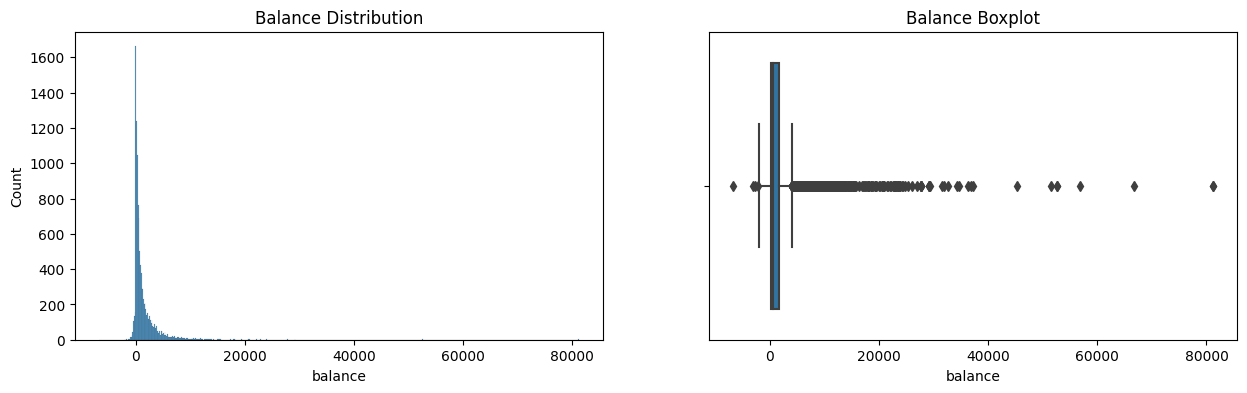

In [14]:
# удалите все выбросы для признака balance
# посмотрим на распределение баланса
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title('Balance Distribution')
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title('Balance Boxplot')

In [15]:
# определим верхнюю и нижнюю границы  Тьюки

x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print(f'Нижняя граница Тьюки:{lower_bound}')
print(f'Верхняя граница Тьюки:{upper_bound}')

def outliers_iqr(data, feature):
    """Функция ищет выбросы по методу Тьюкки

    Args:
        data([DataFrame]): дата фрэйм 
        feature ([string]): Признак в котором мы ищем выбросы
    Returns:
        outliers ([Series]) : Выбросы 
        cleaned ([Series]) : Очищенный от выбросов признак
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned


outliers, cleaned = outliers_iqr(df, 'balance')

print(f'Результирующее число записей: {cleaned.shape[0]}')


Нижняя граница Тьюки:-2241.0
Верхняя граница Тьюки:4063.0
Результирующее число записей: 10105


(10105, 17)

Text(0.5, 1.0, 'Balance Boxplot')

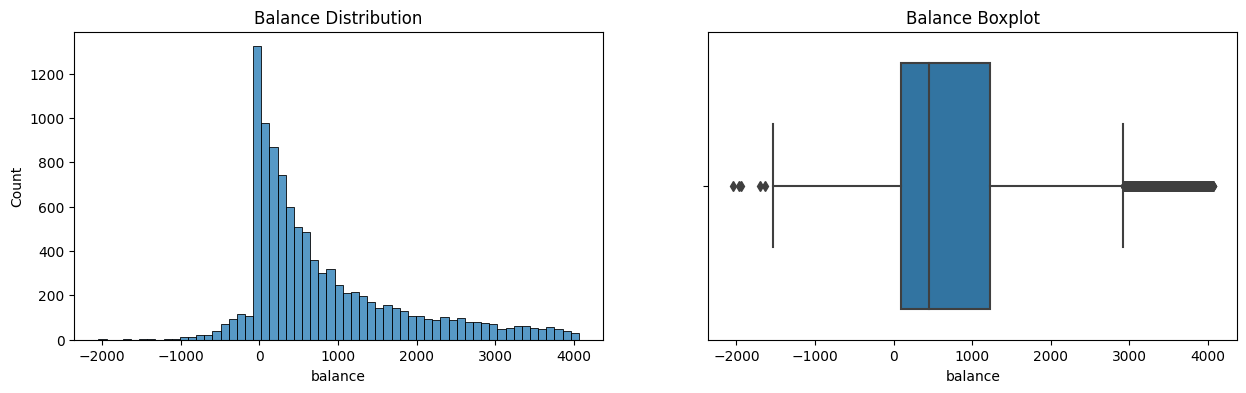

In [63]:
# создадим df соответсвующий записям баланса без выбросов
df_n = df[(df['balance']>=lower_bound) & (df['balance']<= upper_bound)]

display(df_n.shape)
# посмотрим на гистограмму и коробчатую диаграмму распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_n, x='balance', ax=axes[0])
histplot.set_title('Balance Distribution')
boxplot = sns.boxplot(data=df_n, x='balance', ax=axes[1])
boxplot.set_title('Balance Boxplot')

In [17]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [18]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат


display(df_n['deposit'].value_counts())

no     5424
yes    4681
Name: deposit, dtype: int64

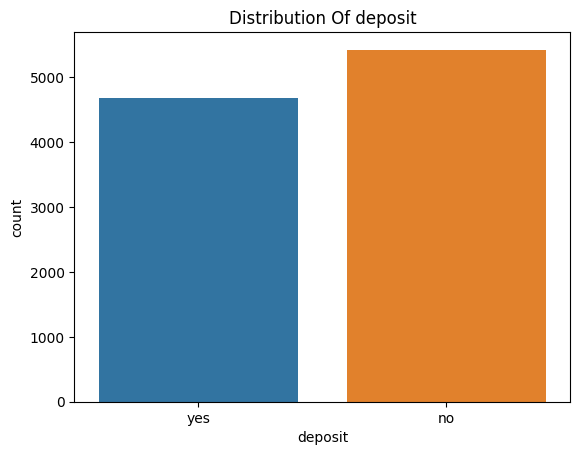

In [19]:
pl = sns.countplot(x=df_n["deposit"])
pl.set_title("Distribution Of deposit")
plt.show()

### Задания 2 и 3

In [20]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_n.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [21]:
# выберем колличественные признаки
number_f = df_n.select_dtypes(include=['int64', 'float64']).columns 

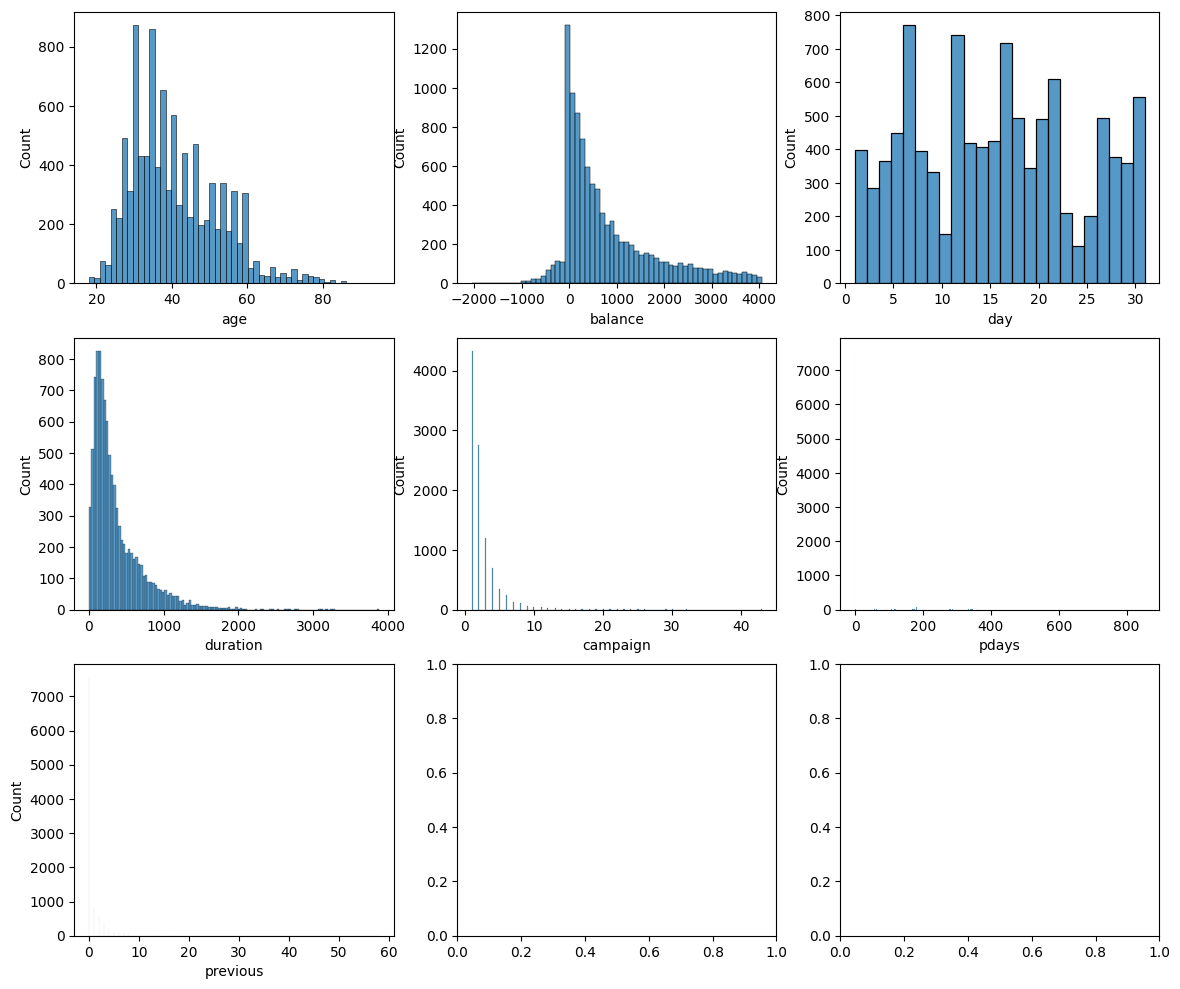

In [22]:
# построим диаграммы распределения признаков
fig, axes = plt.subplots(3,3, figsize = (14,12))

for i, ax in zip(number_f, axes.flat):
    sns.histplot(data = df_n[i], ax = ax)
    #ax.set_title(i)
plt.show()

### Задания 4 и 5

In [23]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

types = df_n.dtypes
cat_features = list(types[(types == 'object')].index) # создадим список категориальных переменных
display(cat_features)


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

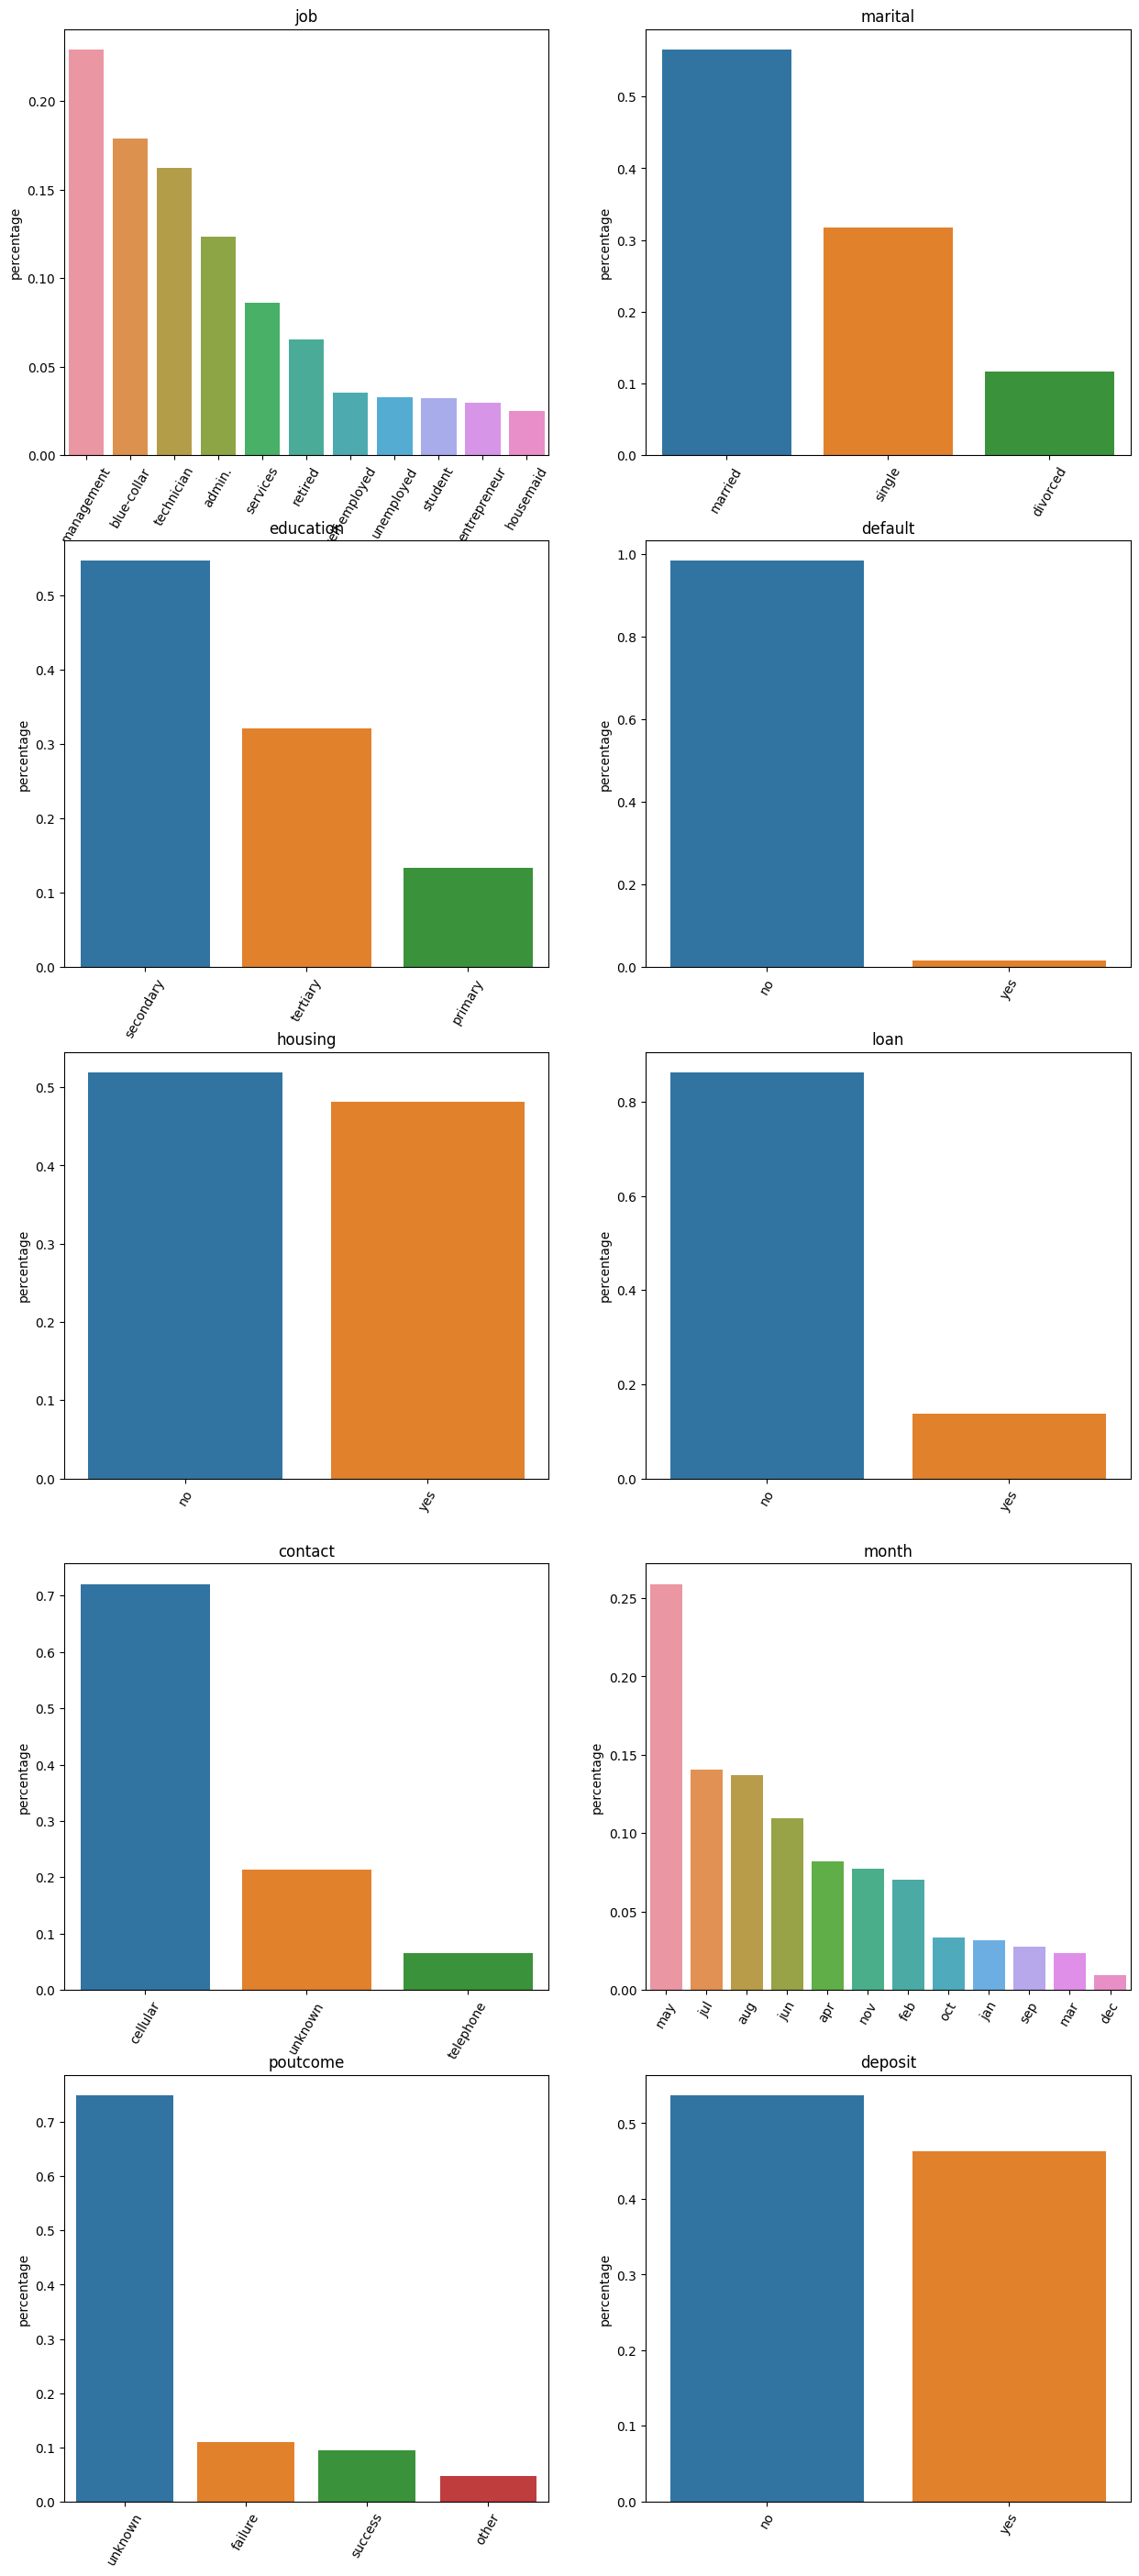

In [25]:

fig, axes = plt.subplots(5, 2, figsize=(15, 35)) #

#Создаем цикл для всех признаков из списка категориальных признаков
for feature, ax in zip(cat_features, axes.flat):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df_n[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=ax)
    count_barplot.set (xlabel='')
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(feature)

In [26]:
display(df_n['job'].value_counts().count())

11

### Задание 6

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

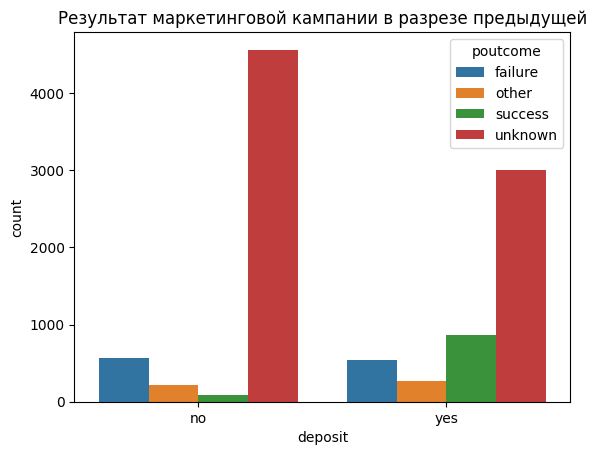

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
pivot = df_n.groupby('poutcome')['deposit'].value_counts().rename('count').reset_index()

boxplot = sns.barplot(data = pivot, x = 'deposit', y ='count', hue ='poutcome' )
boxplot.set_title('Результат маркетинговой кампании в разрезе предыдущей')
display(df_n.groupby('poutcome')['deposit'].value_counts())

Ответ: Success

### Задание 7

Text(0.5, 1.0, 'Распределение решений об открытии депозита в зависимости от месяца')

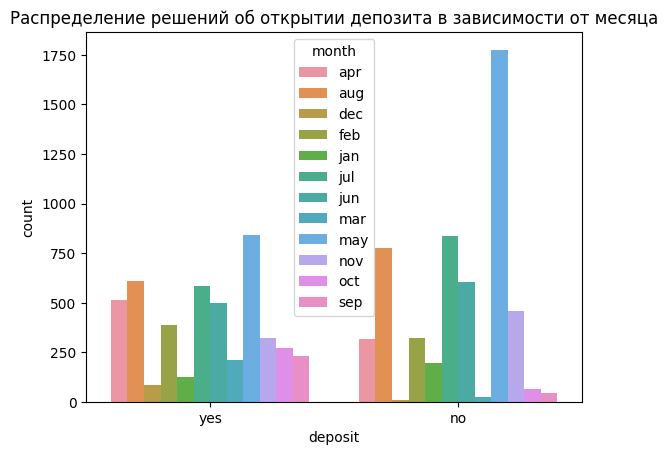

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
pivot = df_n.groupby('month')['deposit'].value_counts().rename('count').reset_index()

barplot = sns.barplot(data = pivot, x = 'deposit', y ='count', hue ='month' )
barplot.set_title('Распределение решений об открытии депозита в зависимости от месяца')

Ответ : май

### Задание 8

Text(0.5, 1.0, 'Распределение решения об открытии депозита в зависимости от возраста')

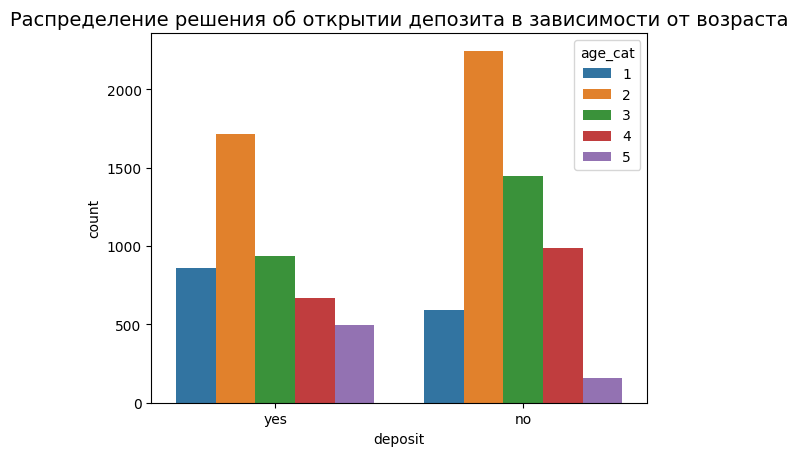

In [29]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_cat(age):
    """Функция кодирует признак возраста на категории

    Args:
        age([int64]): возраст
    Returns:
        cat ([int]) : категория к которой относится входной возраст
    """
    if age < 30:
        return 1
    elif age >= 30 and age < 40:
        return 2
    elif age >= 40 and age < 50:
        return 3
    elif age >= 50 and age < 60:
        return 4
    elif age >= 60:
        return 5

df_n['age_cat'] = df_n['age'].apply(age_cat)

pivot  = df_n.groupby('age_cat')['deposit'].value_counts().rename('count').reset_index()

barplot = sns.barplot(data = pivot, x = 'deposit', y = 'count', hue ='age_cat')
barplot.set_title('Распределение решения об открытии депозита в зависимости от возраста' , fontsize=14)

Ответ: группы 1 и 5

### Задания 9 и 10

Text(0.5, 1.0, 'Распределение решения об открытии депозита в зависимости от семейного статуса')

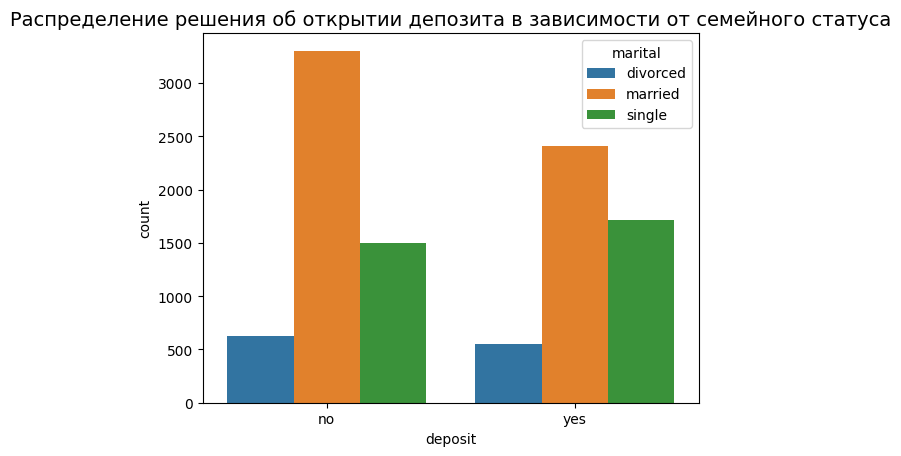

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса


pivot  = df_n.groupby('marital')['deposit'].value_counts().rename('count').reset_index()

barplot = sns.barplot(data = pivot, x = 'deposit', y = 'count', hue ='marital')
barplot.set_title('Распределение решения об открытии депозита в зависимости от семейного статуса' , fontsize=14)

Text(0.5, 1.0, 'Распределение решения об открытии депозита в зависимости от образования')

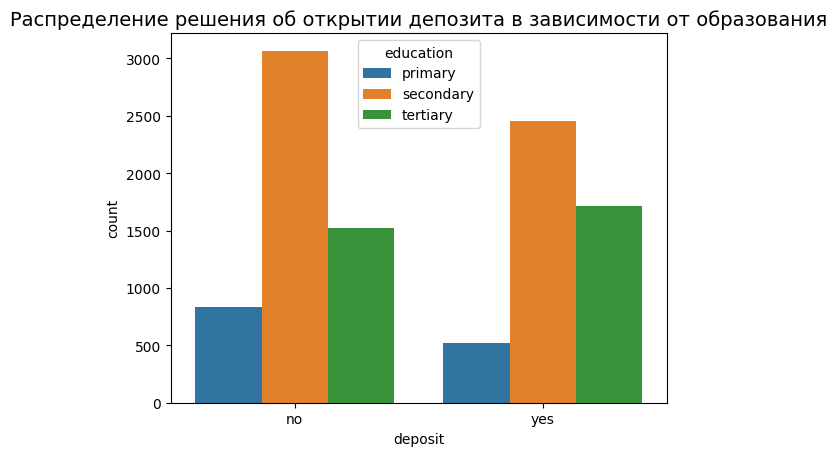

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
pivot  = df_n.groupby('education')['deposit'].value_counts().rename('count').reset_index()

barplot = sns.barplot(data = pivot, x = 'deposit', y = 'count', hue ='education')
barplot.set_title('Распределение решения об открытии депозита в зависимости от образования' , fontsize=14)

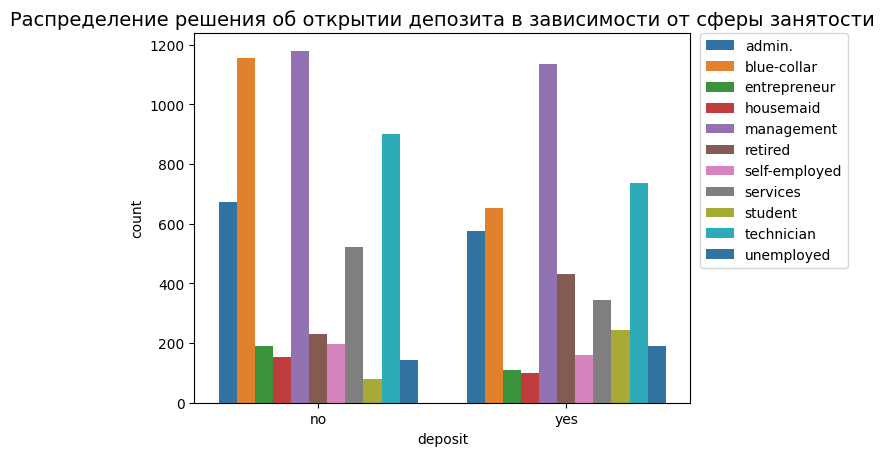

In [32]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости


pivot  = df_n.groupby('job')['deposit'].value_counts().rename('count').reset_index()

barplot = sns.barplot(data = pivot, x = 'deposit', y = 'count', hue ='job', palette= 'tab10')
barplot.set_title('Распределение решения об открытии депозита в зависимости от сферы занятости' , fontsize=14)

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 )

### Задание 11

Text(50.722222222222214, 0.5, 'Семейный статус')

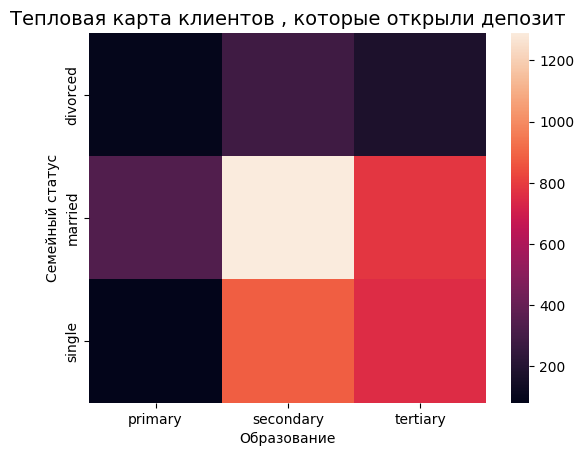

In [33]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# создаем сводную таблицу для тех кто открыл депозит
education_marital_yes = df_n[ df_n['deposit'] == 'yes'].pivot_table(
    values= 'deposit',
    columns ='education',
    index ='marital',
    aggfunc = 'count',
    fill_value= 0
)


# Строим тепловую карту с посощью Seaborn

heatmap = sns.heatmap( data = education_marital_yes )
heatmap.set_title('Тепловая карта клиентов , которые открыли депозит', fontsize=14)
heatmap.set_xlabel('Образование')
heatmap.set_ylabel('Семейный статус')


Ответ: married + secondary

Text(50.722222222222214, 0.5, 'Семейный статус')

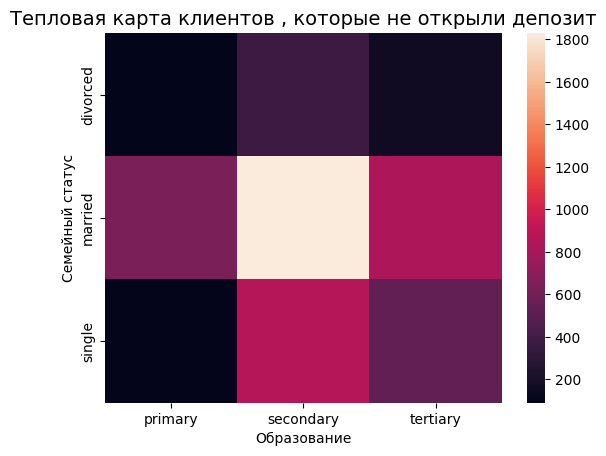

In [34]:
# создаем сводную таблицу для тех кто не открыл депозит
education_marital_yes = df_n[ df_n['deposit'] == 'no'].pivot_table(
    values= 'deposit',
    columns ='education',
    index ='marital',
    aggfunc = 'count',
    fill_value= 0
)


# Строим тепловую карту с посощью Seaborn

heatmap = sns.heatmap( data = education_marital_yes )
heatmap.set_title('Тепловая карта клиентов , которые не открыли депозит', fontsize=14)
heatmap.set_xlabel('Образование')
heatmap.set_ylabel('Семейный статус')

## Часть 3: преобразование данных

### Задание 1

In [35]:
# преобразуйте уровни образования
LE=LabelEncoder()
df_n['education'] = LE.fit_transform(df_n['education'])

display(df_n['education'].sum())

11995

In [36]:
# преобразуем категории возрастов

df_n['age_cat'] = LE.fit_transform(df_n['age_cat'])


### Задания 2 и 3

In [37]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df_n['deposit'] = df_n['deposit'].apply(lambda x : 1 if x =='yes' else 0)

In [38]:
df_n['deposit'].std()

0.4986712532452124

In [39]:
# преобразуем бинарные переменные default , housing , loan в представление из нулей и единиц

df_n['default'] = df_n['default'].apply(lambda x : 1 if x =='yes' else 0)
df_n['housing'] = df_n['housing'].apply(lambda x : 1 if x =='yes' else 0)
df_n['loan'] = df_n['loan'].apply(lambda x : 1 if x =='yes' else 0)

In [40]:
display(f"Сумма средних арифметических default housing loan: {round(df_n['default'].mean() + df_n['housing'].mean() + df_n['loan'].mean()  ,3)}")

'Сумма средних арифметических default housing loan: 0.635'

### Задание 4

In [41]:
# создайте дамми-переменные

display(df_n.head())

#сделаем копию данных
df_nc = df_n.copy()

# закодируем категориальные переменные 
df_nd = pd.get_dummies(df_nc) # Этот способ удаляет исходные категориальные признаки 

# способ который оставит категориальные признаки 
cat_features = ['job','marital', 'contact' , 'month',  'poutcome' ]
df1 = pd.get_dummies(df_nc[cat_features])
df_nd = pd.concat([df_nc,df1], axis=1)
display(df_nd.head())

#способ кодирования через OheHotEncoder
from sklearn.preprocessing  import OneHotEncoder
OH = OneHotEncoder()
cat_features = ['job','marital', 'contact' , 'month',  'poutcome' ]

data_onehot =OH.fit_transform(df_nc[cat_features]).toarray()
column_names = OH.get_feature_names_out(cat_features)
df_OH = pd.DataFrame(data_onehot, index=df_nc.index, columns=column_names)

df_nd = pd.concat([df_nc, df_OH], axis = 1)

display(df_nd.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,3
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,3
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,2
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,3
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,3


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
df_nd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

### Задания 5 и 6

<AxesSubplot: >

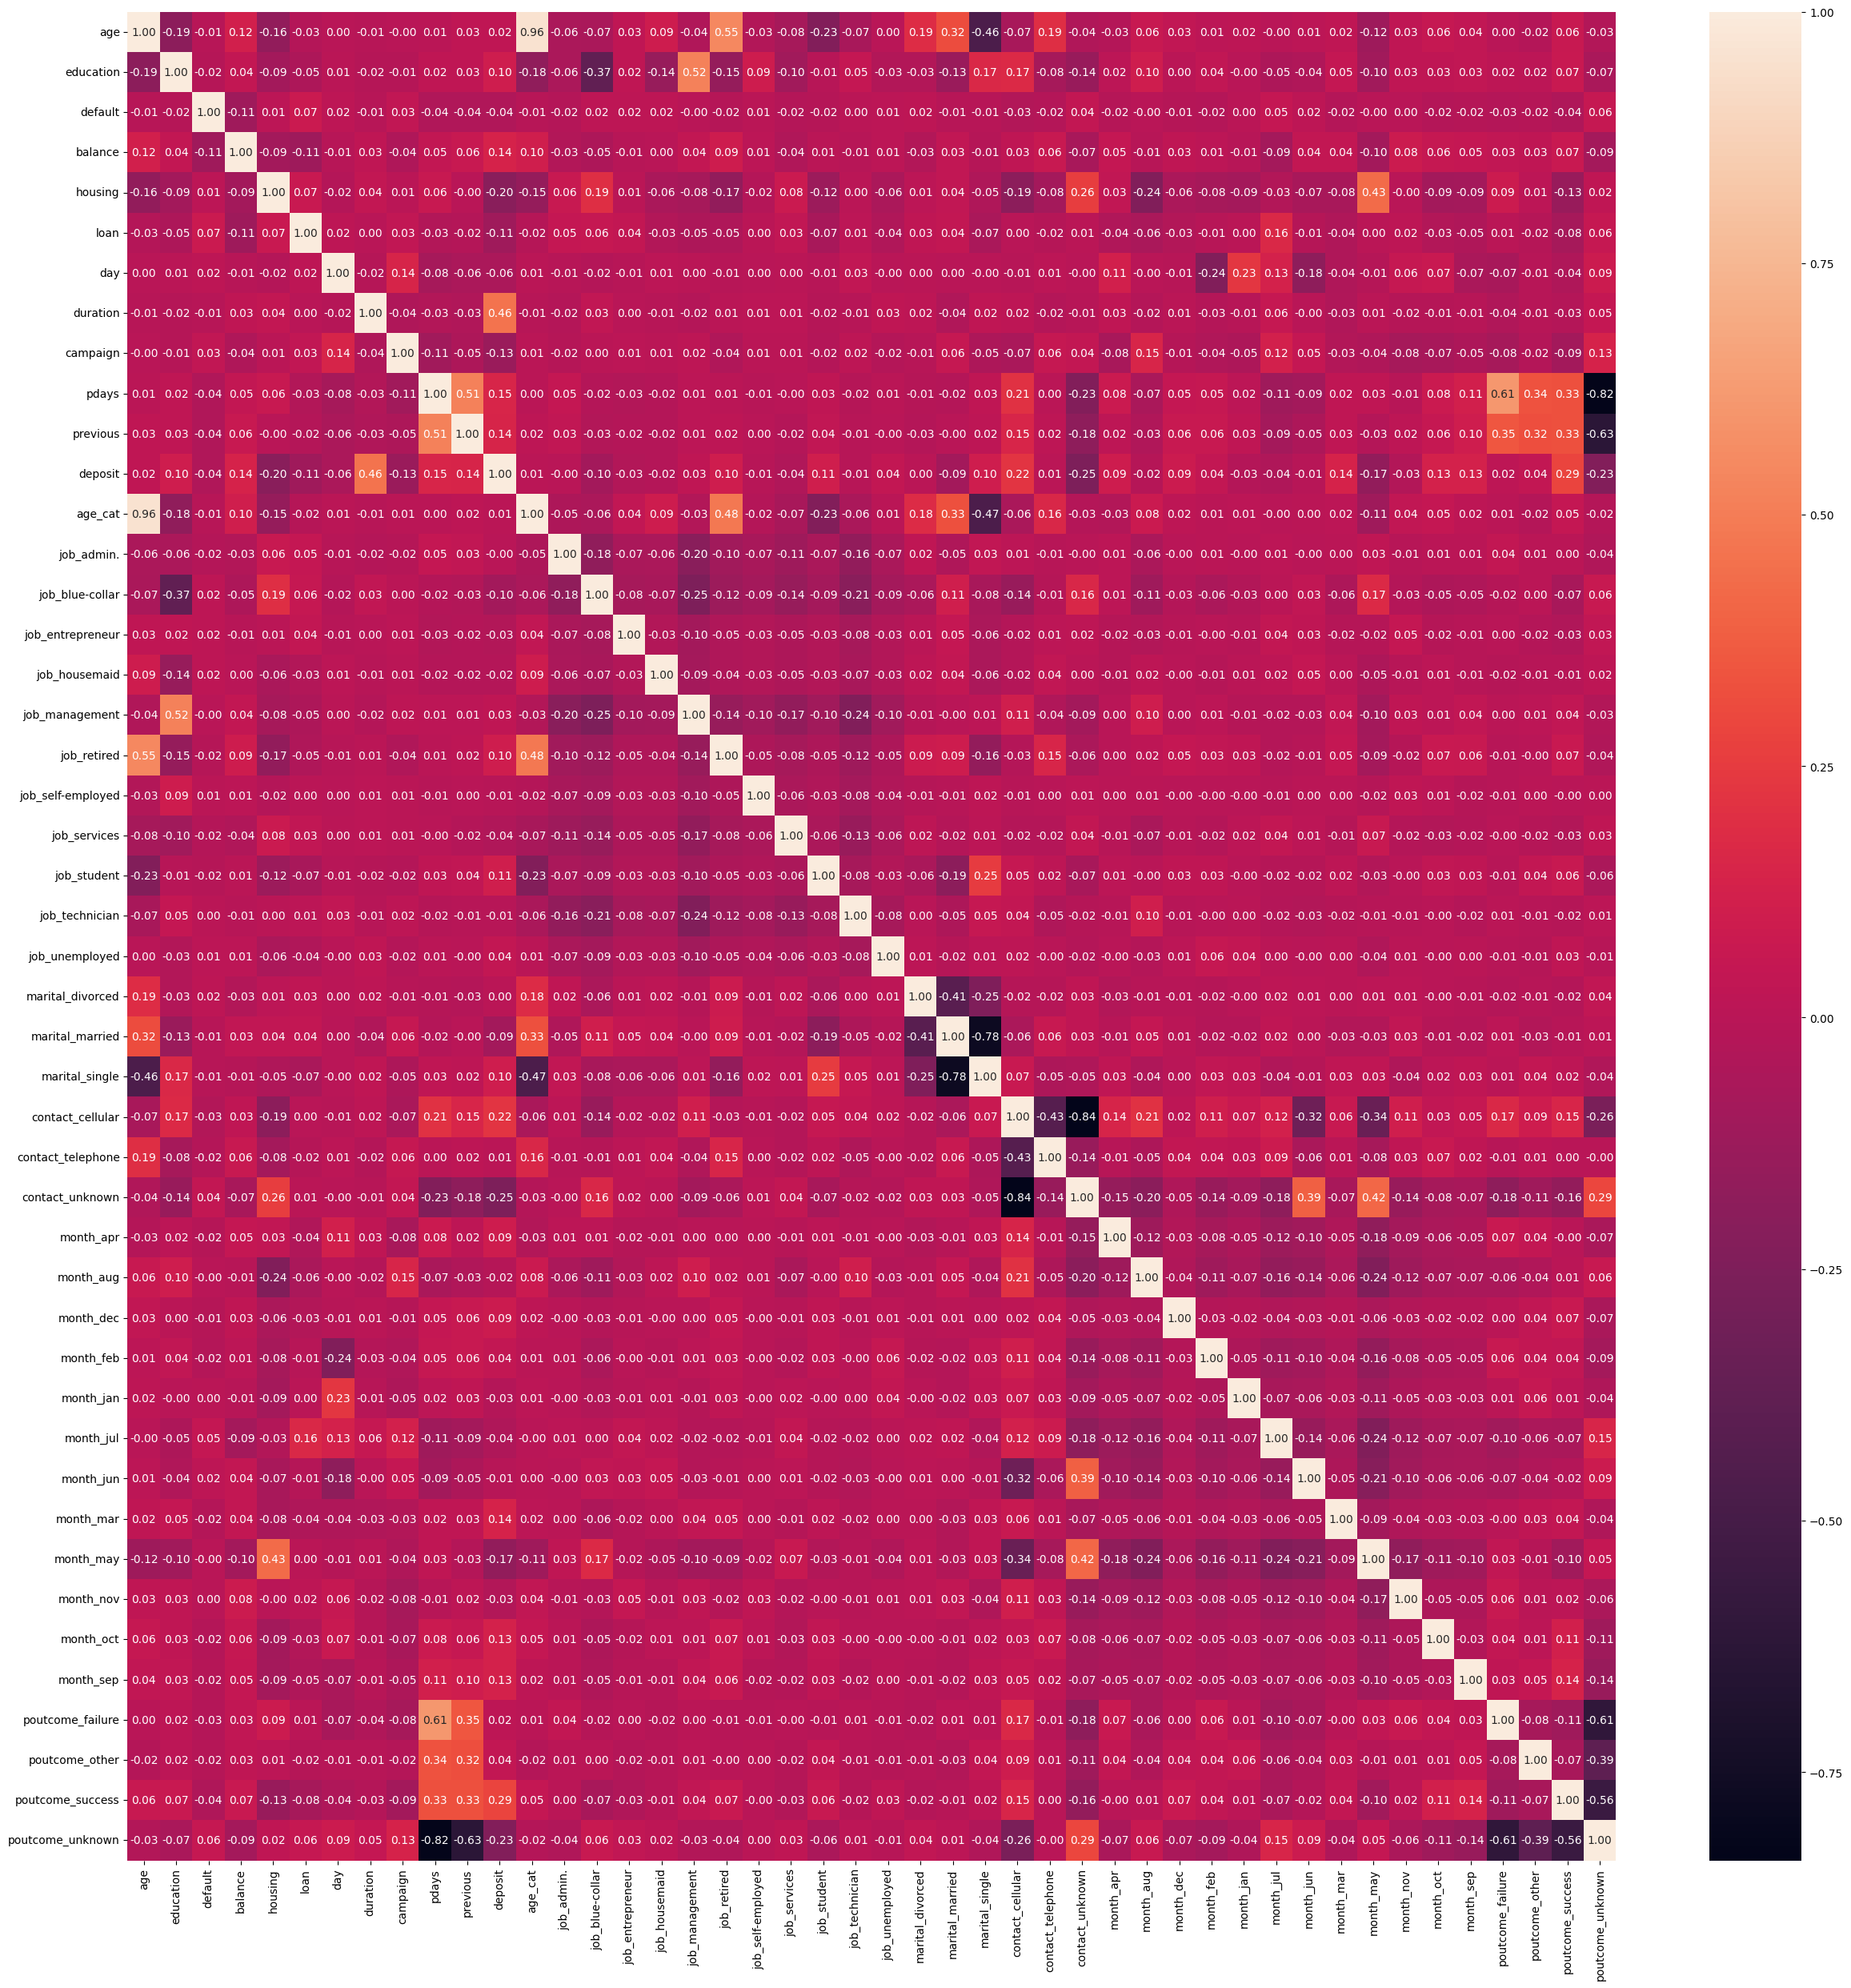

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

cor_matrix = df_nd.corr()

plt.figure(figsize=(30,30))  
sns.heatmap(cor_matrix, fmt='.2f',annot=True)

In [44]:
cor_matrix['deposit']

age                  0.024357
education            0.098253
default             -0.038872
balance              0.135893
housing             -0.200290
loan                -0.107240
day                 -0.056878
duration             0.457818
campaign            -0.130707
pdays                0.147917
previous             0.141102
deposit              1.000000
age_cat              0.006365
job_admin.          -0.001927
job_blue-collar     -0.095845
job_entrepreneur    -0.032706
job_housemaid       -0.022572
job_management       0.029566
job_retired          0.100090
job_self-employed   -0.005194
job_services        -0.040433
job_student          0.105563
job_technician      -0.011190
job_unemployed       0.039196
marital_divorced     0.004808
marital_married     -0.094246
marital_single       0.097005
contact_cellular     0.223944
contact_telephone    0.007064
contact_unknown     -0.249294
month_apr            0.092888
month_aug           -0.018225
month_dec            0.085041
month_feb 

Text(0, 0.5, 'Коэффициент корреляции')

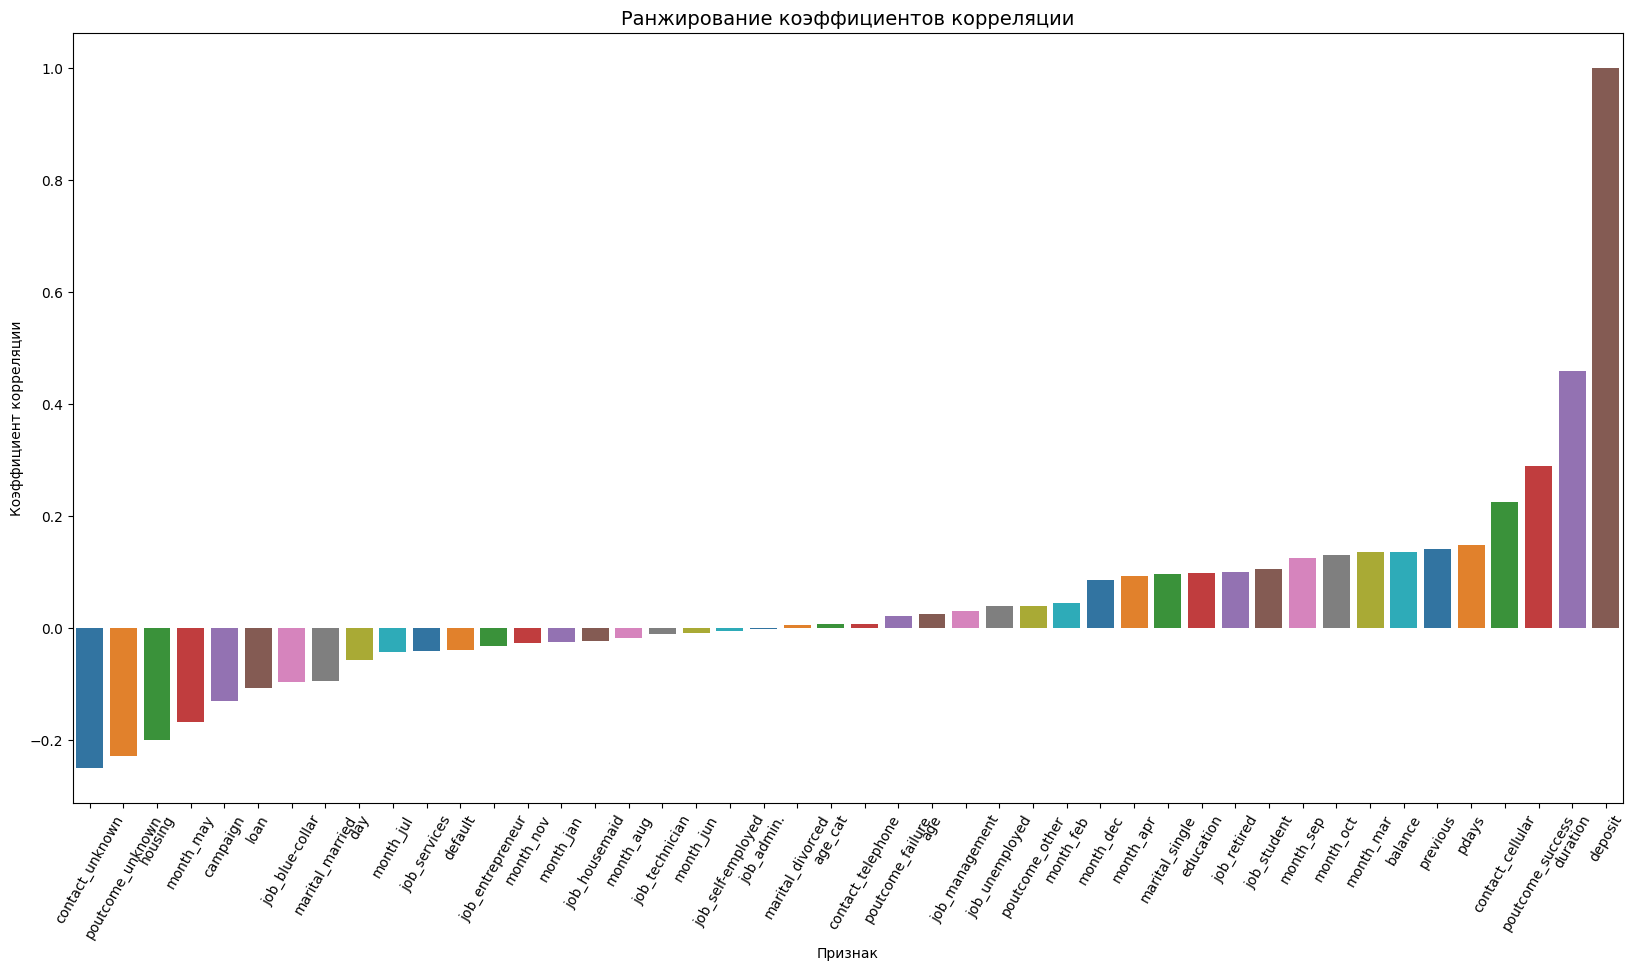

In [45]:
plt.figure(figsize=(20,10)) 
new_cor = cor_matrix['deposit'].reset_index().sort_values('deposit')
barplot = sns.barplot(data = new_cor, x = 'index', y = 'deposit', palette= 'tab10' )
barplot.xaxis.set_tick_params(rotation=60)
barplot.set_title('Ранжирование коэффициентов корреляции', fontsize=14)
barplot.set_xlabel('Признак')
barplot.set_ylabel('Коэффициент корреляции')

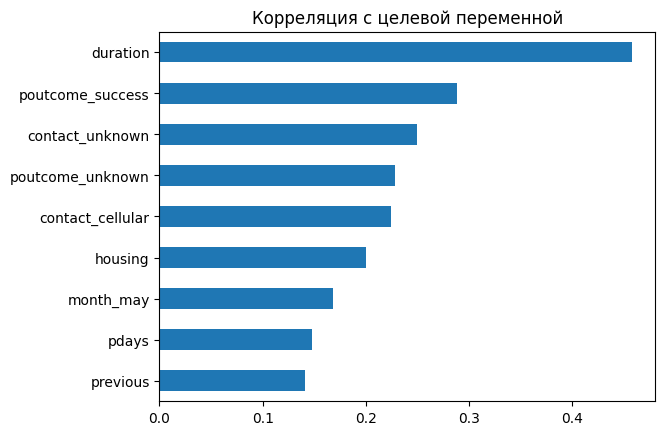

In [46]:
cor_matrix['deposit'].apply(lambda x: abs(x)).sort_values()[-10:-1].plot.barh()
plt.title('Корреляция с целевой переменной')
plt.show()

### Задания 7 и 8

In [47]:
df_copy = df_nd.copy()

# удалим категориальные признаки
df_nd = df_nd.drop(cat_features, axis = 1)
# создадим тренировочную и тестовую выборки
X = df_nd.drop(['deposit'], axis=1)
y = df_nd['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [48]:
# размер текстовой выборки
X_test.shape

(3335, 45)

In [49]:
# среднее значение целевой переменной на тестовой выборке
round(y_test.mean(), 2)

0.46

### Задание 9

In [50]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# оставим только нужные нам признаки   
df_nd= df_nd[list(selector.get_feature_names_out())]

# разделим df с 15 отобранными признаками на тестовую и тренировочные выборки

X = df_nd
y = df_copy['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)


### Задание 10

In [51]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
X_test_scaled[:,0].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [53]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42, solver = 'sag' )

#Обучаем модель
log_reg.fit(X_train_scaled, y_train)

# делаем предсказания для тренировочной выборке
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

print("accuracy на тестовом наборе: {}".format(log_reg.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

accuracy на тестовом наборе: 0.8041979010494753


### Задания 2,3,4

In [54]:
# обучите решающие деревья, настройте максимальную глубину

#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Обучаем дерево по алгоритму 
dt.fit(X_train_scaled, y_train)


# делаем предсказания для ренировочной выборке
y_train_pred = dt.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = dt.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

print("accuracy на тестовом наборе: {}".format(dt.score(X_test_scaled, y_test)))

# методом подбора максимальная accuracy на глубине = 6

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

accuracy на тестовом наборе: 0.7535232383808096


In [56]:
# рассчитаем метрику с наилучшим параметром max_depth
dt = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth = 6)


dt.fit(X_train_scaled, y_train)


# делаем предсказания для ренировочной выборке
y_train_pred = dt.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = dt.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

print("accuracy на тестовом наборе: {}".format(dt.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

accuracy на тестовом наборе: 0.8041979010494753


### Задание 5

In [57]:
# подберите оптимальные параметры с помощью gridsearch


param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion ='entropy'), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 141 ms
Wall time: 216 ms
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [58]:
# обучите на ваших данных случайный лес

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier( n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10 , random_state = 42 )

#Обучаем модель
rf.fit(X_train_scaled, y_train)

# делаем предсказания для ренировочной выборке
y_train_pred = rf.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

print("accuracy на тестовом наборе: {}".format(rf.score(X_test_scaled, y_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

accuracy на тестовом наборе: 0.8272863568215892


### Задания 2 и 3

In [59]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом



# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 ,
    min_samples_leaf = 5,
    learning_rate = 0.05
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)


# делаем предсказания для ренировочной выборке
y_train_pred = gb.predict(X_train_scaled)

print(metrics.f1_score(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = gb.predict(X_test_scaled)

print(metrics.f1_score(y_test, y_test_pred))

0.8719550281074329
0.8142992723821575


### Задание 4

In [60]:
# объедините уже известные вам алгоритмы с помощью стекинга


# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ( 'dt',  tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth = 6, min_samples_split = 10 )), # дерево решений
    ( 'log_reg', linear_model.LogisticRegression(random_state=42, solver = 'sag' )), # логистическая регрессия
    ('gb', GradientBoostingClassifier( max_depth=5, n_estimators=300, random_state=42 , min_samples_leaf = 5, learning_rate = 0.05)) # градиентный бустинг
 
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator = linear_model.LogisticRegression(random_state=42 )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# делаем предсказания для тренировочной выборке
y_train_pred = reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

# делаем предсказания для теста
y_test_pred = reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))




              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3634
           1       0.85      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

In [61]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга


estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задания 6,7,8

In [62]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
#  напрямую указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)


# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


[I 2023-11-07 19:17:38,042] A new study created in memory with name: RandomForestClassifier
[I 2023-11-07 19:17:38,900] Trial 0 finished with value: 0.8710280373831776 and parameters: {'n_estimators': 109, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8710280373831776.
[I 2023-11-07 19:17:39,504] Trial 1 finished with value: 0.8419243986254297 and parameters: {'n_estimators': 124, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8710280373831776.
[I 2023-11-07 19:17:40,524] Trial 2 finished with value: 0.8592338835253815 and parameters: {'n_estimators': 179, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8710280373831776.
[I 2023-11-07 19:17:41,572] Trial 3 finished with value: 0.8508717310087173 and parameters: {'n_estimators': 178, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8710280373831776.
[I 2023-11-07 19:17:42,431] Trial 4 finished with value: 0.8509510445899594 and parameters: {'n

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
